In [1]:
import RCBS
from RCBS.selections import selection
from RCBS.md_analyser.measurements import *
import MDAnalysis as mda

import nglview as nv

_ColormakerRegistry()

# TOC

0. [Description of module](##Description-of-module)
1. [Step 1](#Step-1): Universe loading
2. [Step 2](#Step-2): Selections definition
3. [Step 3](#Step-3): Measurements

## Description of module

## RCBS module

In [2]:
help(RCBS)

Help on package RCBS:

NAME
    RCBS

PACKAGE CONTENTS
    exceptions
    input (package)
    md_analyser (package)
    qmmm_setup (package)
    selections

FILE
    /home/mcanyelles/miniconda3/envs/py_env/lib/python3.6/site-packages/RCBS.py-0.0a0-py3.6.egg/RCBS/__init__.py




## Selections submodule

In [3]:
help(selections)

Help on module RCBS.selections in RCBS:

NAME
    RCBS.selections

FUNCTIONS
    selection(u, sel_input, sel_type=None)
        This function takes an input number or name and type of selection (atom or residue or none)
        and transforms it into an MDAnalysis selection. The input can also be a list of numbers or name
        and it can combine both types of input by using a list of selection types (of the same lenght).
        
        sel_type: at_num, at_name, res, none
            at_num   -> atom number
            at_name  -> atom name
            res_num  -> residue number
            res_name -> residue name
            none     -> pipes the selection command directly

FILE
    /home/mcanyelles/miniconda3/envs/py_env/lib/python3.6/site-packages/RCBS.py-0.0a0-py3.6.egg/RCBS/selections.py




## MD_analyser submodule

In [3]:
help(RCBS.md_analyser.measurements)

Help on module RCBS.md_analyser.measurements in RCBS.md_analyser:

NAME
    RCBS.md_analyser.measurements

FUNCTIONS
    ang_measure(sel1, sel2, sel3)
        This functions measures the angle between 3 specified atoms and returns the value between 0 and 360 degrees.
        The input selections have to be single atoms.
    
    angle_bool_output(ang, ang1, ang2, mode='tol')
        This function takes an input angle and the upper and lower limits or the central value and the tolerance and outputs
        if it satisfies or not the given criteria.
        All the input values are transformed into the (0, 360) degrees format.
        The input values have to be in degrees, not in radians. They can be transformed using the np.rad2dreg() method, for example.
        
        mode:
            lim -> limit mode, it requires a max and a min value
            tol -> tolerance mode, it requires a central value and a min and max value
    
    dihe_measure(sel1, sel2, sel3, sel4)
        This 

# Step 1

Create a MDAnalysis Universe containing the trajectory that is being analyzed.

In [5]:
route_to_files = '/home/mcanyelles/Calculations/trajectories_finals/DHA_12LOX/'
u = mda.Universe(route_to_files + '3rde_A_HXA_solvatat_ion.prmtop', route_to_files + '5_prod_total_autoimage.nc')

In [6]:
u

<Universe with 63455 atoms>

# Step 2

Define the selections that will be used.

In [7]:
FE   = selection(u, 'FE', sel_type='at_name')
OH1  = selection(u, 8784, sel_type='at_num')

C12  = selection(u, 8814, sel_type='at_num')
H12A = selection(u, 8815, sel_type='at_num')
H12B = selection(u, 8816, sel_type='at_num')
H12  = H12A + H12B #multiple-atoms selections can be also done

C9   = selection(u, 8807, sel_type='at_num')
H9A  = selection(u, 8808, sel_type='at_num')
H9B  = selection(u, 8809, sel_type='at_num')
H9   = H9A + H9B

C15  = selection(u, 8821, sel_type='at_num')
H15A = selection(u, 8822, sel_type='at_num')
H15B = selection(u, 8823, sel_type='at_num')
H15  = H15A + H15B

# Step 3

Calculation of the requires measurements

### Functions that will be used in the example

In [17]:
help(dist_measure) # func for measuring the distance between two given selections

Help on function dist_measure in module RCBS.md_analyser.measurements:

dist_measure(sel1, sel2)
    This function outputs the minimum measured distance between the two input selections.



In [18]:
help(dist_bool_output) # func for outputting a boolen value (T/F) from a given distance and the set limits

Help on function dist_bool_output in module RCBS.md_analyser.measurements:

dist_bool_output(dist, dist1, dist2=0, mode='lim')
    This function takes an input distance and the upper and lower limits or the central value and the tolerance and outputs
    if it satisfies or not the given criteria.
    
    mode:
        lim -> limit mode, it requires a max and a min value
        tol -> tolerance mode, it requires a central value and a min and max value



### Define an array for each measurement and its corresponding boolean array

*__Note:__ It is not necessary to store both the measurement and the boolean arrays, this is just an example of my personal way of doing this kind of analysis.*

In [10]:
dist_C12 = []; dist_H12 = []; dist_C9 = []; dist_H9 = []; dist_C15 = []; dist_H15 = []
bool_C12 = []; bool_H12 = []; bool_C9 = []; bool_H9 = []; bool_C15 = []; bool_H15 = []

### Loop over the trajectory measuring each parameter and the corresponding boolean.

In [11]:
for ts in u.trajectory:
    d_ = dist_measure(C12, OH1)
    dist_C12.append(d_)
    bool_C12.append(dist_bool_output(d_, 3.5))
    d_ = dist_measure(H12, OH1)
    dist_H12.append(d_)
    bool_H12.append(dist_bool_output(d_, 3.5))
    
    d_ = dist_measure(C9, OH1)
    dist_C9.append(d_)
    bool_C9.append(dist_bool_output(d_, 3.5))
    d_ = dist_measure(H9, OH1)
    dist_H9.append(d_)
    bool_H9.append(dist_bool_output(d_, 3.5))
    
    d_ = dist_measure(C15, OH1)
    dist_C15.append(d_)
    bool_C15.append(dist_bool_output(d_, 3.5))
    d_ = dist_measure(H15, OH1)
    dist_H15.append(d_)
    bool_H15.append(dist_bool_output(d_, 3.5))
    

In this step, both distance and boolean arrays are created.

# Step 4

Analysis of the results

Distances can be easily plotted using matplotlib:

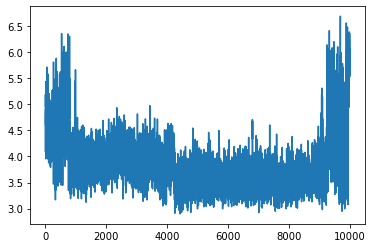

In [13]:
import matplotlib.pyplot as plt

plt.plot(range(0, len(dist_C12)), dist_C12)
plt.show()
plt.close()    

Boolean arrays can be used for counting like follows:

In [16]:
#prints the percentage of frames where the criterium is satisfied

percentage = bool_C12.count(True)/len(bool_C12)*100
print(f'{percentage}% of the frames satisfy the given criteria (dist C12-OH < 3.5)')

24.58% of the frames satisfy the given criteria (dist C12-OH < 3.5)
